<a href="https://colab.research.google.com/github/worldofaryavart/colab_notebooks/blob/colabnotebook/overfit_and_underfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.15.0


In [ ]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-wyhm2o4p
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-wyhm2o4p
  Resolved https://github.com/tensorflow/docs to commit f278011af8e25b060bf7d91640baf175d35ba7da
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.3.27.3713-py3-none-any.whl size=182447 sha256=97bd089aff0cf5bdadb9c14c9fdb88a9b9fe9ae7a3e094c599a01c2e251fed4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-xdg5e9f6/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors = True)

In [ ]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 113s 0us/step


In [ ]:
FEATURES = 28

In [ ]:
ds = tf.data.experimental.CsvDataset(gz,[float(), ]*(FEATURES+1), compression_type = "GZIP")

In [ ]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:], 1)
  return features, label

In [ ]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


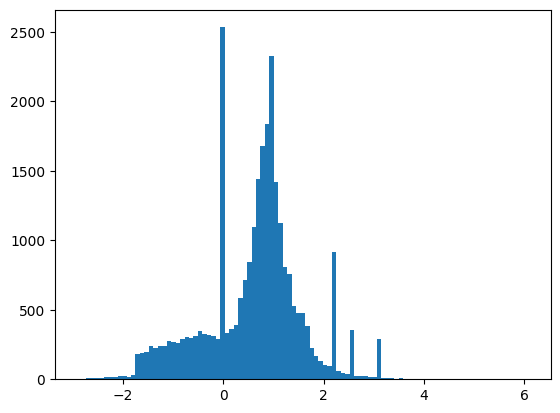

In [ ]:
for features, label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(),bins = 101)


In [ ]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN

In [ ]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [ ]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate = 1,
    staircase = False
)
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

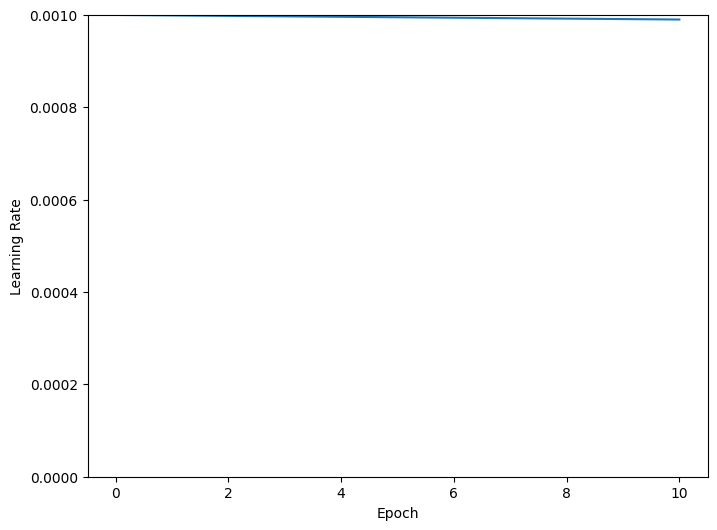

In [ ]:
step  = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
def get_callbacks(name):
  return [
      tfdocs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_crossentropy', patience = 200),
      tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [ ]:
def compile_and_fit(model, name, optimizer = None, max_epochs = 10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                metrics = [
                    tf.keras.metrics.BinaryCrossentropy(
                        from_logits = True, name = 'binary_crossentropy'),
                    'accuracy'])
  model.summary()

  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epochs,
      validation_data = validate_ds,
      callbacks = get_callbacks(name),
      verbose = 0
  )
  return history

In [ ]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation = 'elu', input_shape= (FEATURES,)),
    layers.Dense(1)
])

In [ ]:
size_histories = {}

In [ ]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.6271,  binary_crossentropy:0.6110,  loss:0.6110,  val_accuracy:0.6600,  val_binary_crossentropy:0.5781,  val_loss:0.5781,  
....................................................................................................
Epoch: 100, accuracy:0.7243,  binary_crossentropy:0.5203,  loss:0.5203,  val_accuracy:0.6890,  val_binary_crossentropy:0.6004,  val_loss:0.6004,  
............................

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std = 10)
plotter.plt(size_histories)
plt.ylim([0.5,0.7])